In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from utils.Jet_class_light import json_import_list
from utils.Jet_box_class import make_cluster_box, make_subject_box, plot_all_subject_boxes_and_average_box
from astropy.coordinates import SkyCoord
import sunpy.coordinates  # Needed for helioprojective coordinate frame
from sunpy.net import Fido
from sunpy.net import attrs as a
import pandas as pd
import numpy as np
import os
import random
import shutil
import csv

# Animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from astropy.visualization import ImageNormalize, SqrtStretch

import matplotlib.pyplot as plt
import matplotlib.patches as patches


import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.io import fits

import sunpy.coordinates  # NOQA
import sunpy.map
from sunpy.net import Fido
from sunpy.net import attrs as attrs

import torch

from sunpy.net import jsoc
import sys
import time 
import glob

c:\Users\adrie\anaconda3\envs\ML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
json_file = 'Jet_clusters_3.0_2.0_paperID_cluster_xy_v2.json'
Jet_clusters=json_import_list(json_file)

# Here we have the same format as for the CSV file information
sjh_identifier = np.array([Jet_clusters[i].ID for i in range(len(Jet_clusters))], dtype=str)

# date: Observation time of the start of the jet (format YYYY-MM-DDThh:mm:ss)
Cluster_date = np.array([Jet_clusters[i].obs_time for i in range(len(Jet_clusters))], dtype='datetime64')
# duration of the jet (minutes)
stat_dur = np.array([Jet_clusters[i].Duration for i in range(len(Jet_clusters))], dtype=float)

Cluster_SOL = np.array([Jet_clusters[i].SOL for i in range(len(Jet_clusters))], dtype=str)

stat_Bx = np.array([Jet_clusters[i].Bx for i in range(len(Jet_clusters))], dtype=float)
stat_By = np.array([Jet_clusters[i].By for i in range(len(Jet_clusters))], dtype=float)
stat_Lon = np.array([Jet_clusters[i].Lon for i in range(len(Jet_clusters))], dtype=float)
stat_Lat = np.array([Jet_clusters[i].Lat for i in range(len(Jet_clusters))], dtype=float)
stat_H = np.array([Jet_clusters[i].Max_Height for i in range(len(Jet_clusters))], dtype=float)
stat_W = np.array([Jet_clusters[i].Width for i in range(len(Jet_clusters))], dtype=float)
stat_vel = np.array([Jet_clusters[i].Velocity for i in range(len(Jet_clusters))], dtype=float)
stat_sigma = np.array([Jet_clusters[i].sigma for i in range(len(Jet_clusters))], dtype=float)
std_H = np.array([Jet_clusters[i].std_maxH for i in range(len(Jet_clusters))], dtype=float)
std_W = np.array([Jet_clusters[i].std_W for i in range(len(Jet_clusters))], dtype=float)
std_Bx = np.array([Jet_clusters[i].std_Bx for i in range(len(Jet_clusters))], dtype=float)
std_By = np.array([Jet_clusters[i].std_By for i in range(len(Jet_clusters))], dtype=float)
flags = np.array([Jet_clusters[i].flag for i in range(len(Jet_clusters))], dtype=str)
#angle = np.array([Jet_clusters[i].angle for i in range(len(Jet_clusters))], dtype=float)
jsoc_email = "adrien.joliat@epfl.ch"

The 881 JetCluster objects are imported from Jet_clusters_3.0_2.0_paperID_cluster_xy_v2.json.


Run to define new bounding box from new map

In [4]:
jetid=81
results=glob.glob('./essai_data1/'+str(jetid).zfill(3)+"//aia.lev1_euv_12s.*.304.image.fits")
aia_map=sunpy.map.Map(results[0])
nb_pixels_h=round(aia_map.dimensions[0].value)
nb_pixels_w=round(aia_map.dimensions[1].value)
print(aia_map)
x1=0-aia_map.reference_pixel[0].value*aia_map.scale[0].value
x2=x1+nb_pixels_w*aia_map.scale[0].value

y2=0-aia_map.reference_pixel[1].value*aia_map.scale[1].value
y1=y2+nb_pixels_h*aia_map.scale[1].value
print(x1)#x1
print(x2)#x1
print(y1)
print(y2)

SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 4
Detector:		 AIA
Measurement:		 304.0 Angstrom
Wavelength:		 304.0 Angstrom
Observation Date:	 2011-05-28 09:06:20
Exposure Time:		 2.902176 s
Dimension:		 [928. 928.] pix
Coordinate System:	 helioprojective
Scale:			 [0.60016501 0.60016501] arcsec / pix
Reference Pixel:	 [1992.63989     34.4100342] pix
Reference Coord:	 [0. 0.] arcsec                   
array([[ 1,  2,  0, ..., 58, 58, 66],
       [ 4,  2,  0, ..., 77, 73, 83],
       [ 4,  2,  2, ..., 75, 56, 75],
       ...,
       [ 1,  2,  4, ..., 45, 54, 43],
       [ 0,  0,  5, ..., 47, 51, 43],
       [ 2,  2,  2, ..., 59, 43, 45]], dtype=int16)
-1195.912737515609
-638.959609163609
536.3014298666667
-20.65169848533331


In [5]:
for i in range(881,881):
    jetid=i
    res=glob.glob('./essai_data1/'+str(jetid).zfill(3)+"//aia.lev1_euv_12s.*.304.image.fits")
        
    for i in range(len(res)):
        
        #Define aia map frame
        aia_map = sunpy.map.Map(res[i])

        #In each file there is a value for the dimension
        #so we can define precisely the height/width of the resulting image
        nb_pixels_h=round(aia_map.dimensions[0].value)
        nb_pixels_w=round(aia_map.dimensions[1].value)

        #We can now define each corner of the image in arcsec !
        x1=0-aia_map.reference_pixel[0].value*aia_map.scale[0].value
        x2=x1+nb_pixels_w*aia_map.scale[0].value

        y2=0-aia_map.reference_pixel[1].value*aia_map.scale[1].value
        y1=y2+nb_pixels_h*aia_map.scale[1].value

        #Define which jet box should be used
        subjects_start_time = []
        for jet in Jet_clusters[jetid].jets:
            subjects_start_time.append(jet.time)
        subject_idn = np.max(np.where(subjects_start_time < aia_map.date.datetime64))
        #print(subject_idn)
        subject_box = make_subject_box(Jet_clusters[jetid].jets[subject_idn])
        

        #Get the coordinates of the bounding box in arcsec
        #Get the upper rectangle without any angle such that the whole rectangle is contained into the new one without angle
        [[x1_bb,y1_bb],[x2_bb,y2_bb],[x3_bb,y3_bb],[x4_bb,y4_bb]] = subject_box.corners()
        xmin_bb=min(x1_bb,x2_bb,x3_bb,x4_bb).value
        xmax_bb=max(x1_bb,x2_bb,x3_bb,x4_bb).value
        ymin_bb=min(y1_bb,y2_bb,y3_bb,y4_bb).value
        ymax_bb=max(y1_bb,y2_bb,y3_bb,y4_bb).value
        #print(xmin_bb,ymin_bb,xmax_bb,ymax_bb) #arcsec

        #Transform arcsec value into pixel value
        #####For y value:
        b=nb_pixels_h/(1-y1/y2)
        a=-b/y2
        ymin_bb_fin=a*ymax_bb+b #give us ymin (for upper left)
        ymax_bb_fin=a*ymin_bb+b

        ######For x value
        b=nb_pixels_w/(1-x2/x1)
        a=-b/x1
        xmin_bb_fin=a*xmin_bb+b
        xmax_bb_fin=a*xmax_bb+b
        #print(xmin_bb_fin,ymin_bb_fin,xmax_bb_fin,ymax_bb_fin) #pixel value
        data=[[xmin_bb_fin,ymin_bb_fin,xmax_bb_fin,ymax_bb_fin]]

        output_path_fold_bbox=f"./bbox_events_jets_v2/{str(jetid).zfill(3)}"
        if not os.path.exists(output_path_fold_bbox): os.mkdir(output_path_fold_bbox)

        csv_file_path = output_path_fold_bbox+f"/{str(jetid).zfill(3)}_{str(i).zfill(3)}.csv"

        # Write data to CSV file
        with open(csv_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["xmin", "ymin", "xmax", "ymax"])  # Write header
            for row in data:
                writer.writerow(row)

Final Dataset Exemples

2024-05-13 21:02:48 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.HTMLWriter'>


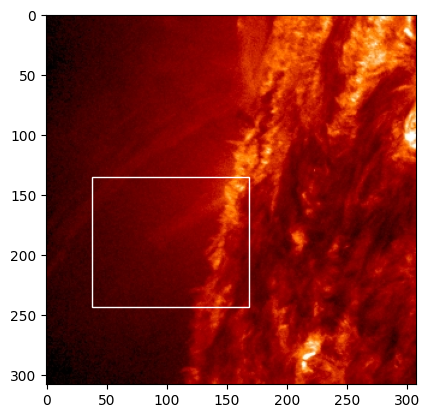

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from IPython.display import HTML
import os
import matplotlib

matplotlib.rcParams['animation.embed_limit'] = 50  # Set to a larger value (in MB)

jetid=60 #good exemple jetid 67
folder_path = f"../TransVOD/TransVOD_Lite-main/data/vid/Data/VID/TRAIN/{str(jetid).zfill(3)}"
if not os.path.exists(folder_path):
    folder_path=f"../TransVOD/TransVOD_Lite-main/data/vid/Data/VID/VAL/{str(jetid).zfill(3)}"
file_names = sorted(os.listdir(folder_path))

def read_image_with_bbox(bbox):

    # Read bounding box coordinates (replace with your actual values)
    x_min, y_min = bbox[0], bbox[1]
    x_max, y_max = bbox[2], bbox[3]

    # Calculate rectangle width and height
    width = x_max - x_min
    height = y_max - y_min

    return x_min, y_min, width, height

def update(frame):
    # Read image and bounding box for the current frame
    image_file = file_names[frame]
    image_path = os.path.join(folder_path, image_file)
    image = plt.imread(image_path)

    final_bbox=pd.read_csv(f"./bbox_events_jets_v2/{str(jetid).zfill(3)}/{str(jetid).zfill(3)}_{str(frame).zfill(3)}.csv").values.tolist()
    #print(final_bbox)
    # Update the image with the loaded image
    im.set_data(image)

    for rect in rects:
        rect.remove()

    # Create new rectangles
    rects.clear()  # Clear the list of rectangles


    for bbox in final_bbox:
        x_min, y_min, width, height = read_image_with_bbox(bbox)
        rect_params = {
            'xy': (x_min, y_min),
            'width': width,
            'height': height,
            'linewidth': 1,
            'edgecolor': 'w',
            'facecolor': 'none'
        }
        rect = Rectangle(**rect_params)
        ax.add_patch(rect)
        rects.append(rect)

    return im, 
    
# Create a figure and axis
fig, ax = plt.subplots()

file_path=os.path.join(folder_path, file_names[0])
image = plt.imread(file_path)
# Initialize the animation with the first image
im = plt.imshow(image)
rects = []

# Create the animation
ani = FuncAnimation(fig, update, frames=len(file_names), interval=100)

# Display the animation as a clickable animation in the notebook
HTML(ani.to_jshtml())

In [15]:
#ani.save("Animation_test.gif", dpi=400)

2024-05-12 09:01:02 - matplotlib.animation - WARNING: MovieWriter ffmpeg unavailable; using Pillow instead.
2024-05-12 09:01:02 - matplotlib.animation - INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


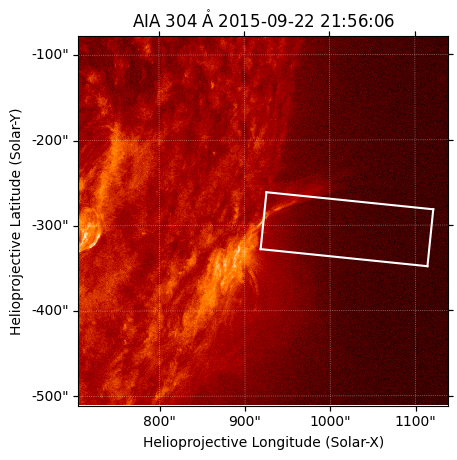

In [9]:
frame=0
selected_jet = Jet_clusters[jetid]
jet_box = make_cluster_box(selected_jet)

data_path = './essai_data1/'+str(jetid).zfill(3)

files = glob.glob(data_path+"//aia.lev1_euv_12s.*.304.image.fits")
#len(files)
aia_map = sunpy.map.Map(files[frame])


fig = plt.figure()
ax = fig.add_subplot(projection=aia_map)
image = aia_map.plot(axes=ax)

# Note that the coordinates need to be in degrees rather than arcseconds.
for line in jet_box.lines_to_plot():
    ax.plot(line[0]*u.arcsec.to(u.deg), line[1]*u.arcsec.to(u.deg),
            color='white',
            transform=ax.get_transform("world"))

plt.show()

## Verifying jets events matching with bounding box

In [6]:
images_folder_1 = f"../TransVOD/TransVOD_Lite-main/data/vid/Data/VID/TRAIN/"
images_folder_2 = f"../TransVOD/TransVOD_Lite-main/data/vid/Data/VID/VAL/"

folders_in_folder1 = [f for f in os.listdir(images_folder_1) if os.path.isdir(os.path.join(images_folder_1, f))]

# Get the list of folders in the second folder
folders_in_folder2 = [f for f in os.listdir(images_folder_2) if os.path.isdir(os.path.join(images_folder_2, f))]

# Merge both lists of folders
all_folders = folders_in_folder1 + folders_in_folder2
print(all_folders)

['000', '001', '002', '003', '004', '005', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '026', '028', '029', '032', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '047', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '062', '063', '064', '065', '066', '067', '069', '070', '071', '073', '075', '076', '078', '079', '080', '081', '082', '083', '084', '085', '088', '089', '090', '091', '092', '093', '094', '096', '097', '098', '099', '102', '103', '104', '106', '107', '108', '111', '112', '113', '114', '117', '119', '120', '121', '122', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '169', '170', '171'

In [9]:
# Path to the parent folders

parent_folder2 = "./bbox_events_jets_v2"

# Get list of folder names in parent_folder1
folders1 = all_folders

# Get list of folder names in parent_folder2
folders2 = next(os.walk(parent_folder2))[1]

# Find folders that are in one parent folder but not in the other
unique_folders1 = set(folders1) - set(folders2)
unique_folders2 = set(folders2) - set(folders1)

# Output the unique folder names
print("Folders unique to images:", sorted(unique_folders1))
print("Folders unique to bbox:", sorted(unique_folders2))
if sorted(unique_folders1)==[] and sorted(unique_folders2)==[]:
    print("ALL EVENTS ARE MATCHING")
    print(f"There is a total of {len(folders1)} events in the dataset")

for folder_name in unique_folders2:
    folder_path = os.path.join(parent_folder2, folder_name)
    shutil.rmtree(folder_path)

Folders unique to images: []
Folders unique to bbox: []
ALL EVENTS ARE MATCHING
There is a total of 780 events in the dataset
